In [2]:
import re
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

In [3]:

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')


import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict  # Added this import
import re

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-5-18827c858c01>:291: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = concept1.similarity(concept2)


     node_1    node_2        relation  weight   chunk_id
0  children     eager    has_property     0.7  story_1_0
1  children   teacher  co_occurs_with     0.3  story_1_0
2       day  children  co_occurs_with     0.3  story_1_0
3       day     rules  co_occurs_with     0.3  story_1_0
4       day   teacher  co_occurs_with     0.3  story_1_0
Graph visualization saved to knowledge_graph.png
Knowledge graph exported to knowledge_graph.csv
Processing story story_1...
Processing story story_2...


<ipython-input-5-18827c858c01>:291: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = concept1.similarity(concept2)
<ipython-input-5-18827c858c01>:291: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of t

Graph visualization saved to combined_knowledge_graph.png


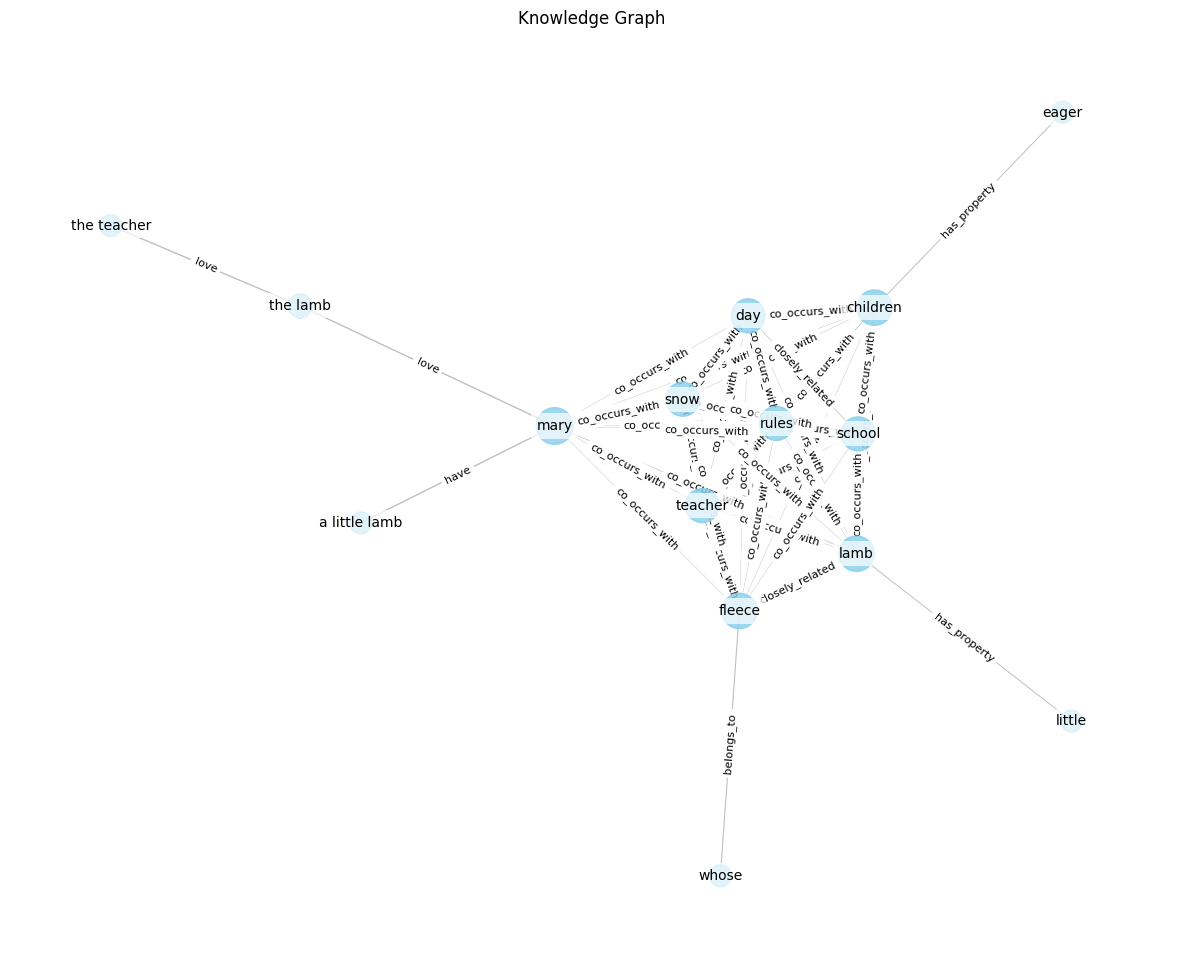

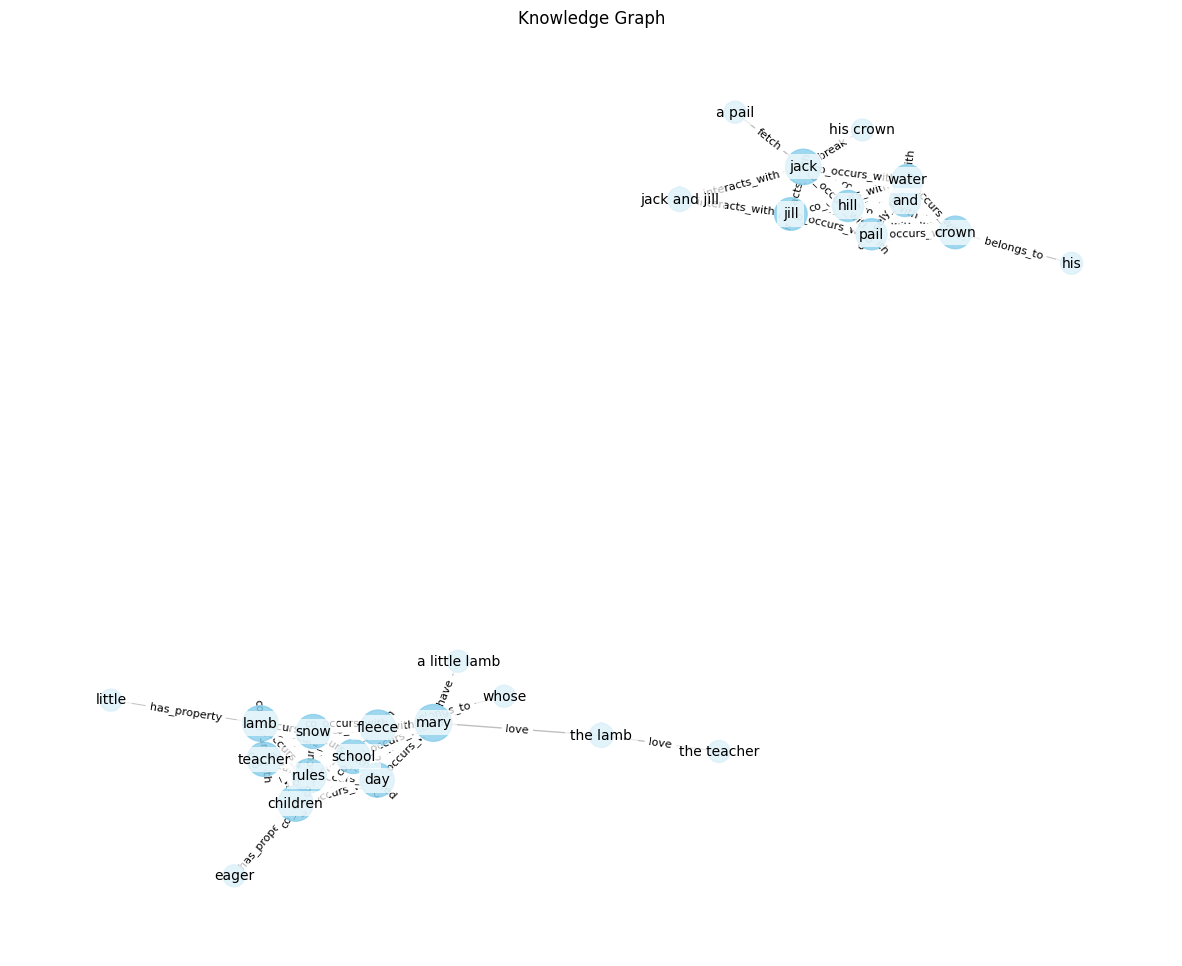

In [5]:
import pandas as pd
import spacy
import nltk
from nltk.tokenize import sent_tokenize
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import re

# Download necessary NLTK data
nltk.download('punkt')

class KnowledgeGraphGenerator:
    def __init__(self, nlp_model="en_core_web_sm"):
        """Initialize the knowledge graph generator with necessary NLP tools."""
        self.nlp = spacy.load(nlp_model)
        self.chunk_size = 300  # Approximate words per chunk
        self.semantic_df = None
        self.contextual_df = None
        self.final_df = None
        self.G = None  # NetworkX graph

    def process_story(self, story_text, story_id):
        """Process a single story to generate a knowledge graph."""
        # Step 1: Split the corpus into text chunks
        chunks = self._split_text_chunks(story_text)

        # Step 2: Extract concept pairs and semantic relationships
        self.semantic_df = self._extract_semantic_relationships(chunks, story_id)

        # Step 3: Add contextual proximity relationships
        self.contextual_df = self._add_contextual_relationships(chunks, story_id)

        # Concatenate the two dataframes
        if self.semantic_df is not None and self.contextual_df is not None:
            self.final_df = pd.concat([self.semantic_df, self.contextual_df], ignore_index=True)
        elif self.semantic_df is not None:
            self.final_df = self.semantic_df
        elif self.contextual_df is not None:
            self.final_df = self.contextual_df
        else:
            self.final_df = pd.DataFrame(columns=['node_1', 'node_2', 'relation', 'weight', 'chunk_id'])

        # Step 4: Group node pairs, sum weights, and concatenate relationships
        self.final_df = self._group_nodes_and_relationships()

        # Create NetworkX graph from final dataframe
        self._create_graph()

        return self.final_df, self.G

    def _split_text_chunks(self, text):
        """Split the story into manageable chunks of text."""
        # First split the text into sentences
        sentences = sent_tokenize(text)

        chunks = []
        current_chunk = []
        current_word_count = 0

        for sentence in sentences:
            sentence_word_count = len(sentence.split())

            # If adding this sentence exceeds chunk size, finalize current chunk
            if current_word_count + sentence_word_count > self.chunk_size and current_chunk:
                chunks.append(' '.join(current_chunk))
                current_chunk = [sentence]
                current_word_count = sentence_word_count
            else:
                current_chunk.append(sentence)
                current_word_count += sentence_word_count

        # Add the last chunk if it's not empty
        if current_chunk:
            chunks.append(' '.join(current_chunk))

        return chunks

    def _extract_semantic_relationships(self, chunks, story_id):
        """Extract concept pairs and the semantic relationship between them."""
        relationships = []

        for idx, chunk in enumerate(chunks):
            doc = self.nlp(chunk)

            # Extract subject-verb-object triplets
            for sent in doc.sents:
                sent_doc = self.nlp(sent.text)

                subjects = []
                verbs = []
                objects = []

                for token in sent_doc:
                    # Find subjects
                    if token.dep_ in ("nsubj", "nsubjpass"):
                        subjects.append(token)
                    # Find verbs
                    elif token.pos_ == "VERB":
                        verbs.append(token)
                    # Find objects
                    elif token.dep_ in ("dobj", "pobj", "attr"):
                        objects.append(token)

                # Create relationships from subject-verb-object combinations
                for subj in subjects:
                    subj_text = self._get_span_text(subj)

                    for verb in verbs:
                        # Skip if the verb isn't related to this subject
                        if verb.head.text != subj.head.text and verb.head != subj:
                            continue

                        verb_text = verb.lemma_

                        for obj in objects:
                            # Skip if the object isn't related to this verb
                            if obj.head != verb:
                                continue

                            obj_text = self._get_span_text(obj)

                            # Skip if subject or object is a pronoun
                            if subj.pos_ == "PRON" or obj.pos_ == "PRON":
                                continue

                            chunk_id = f"{story_id}_{idx}"

                            # Add the relationship
                            relationships.append({
                                'node_1': subj_text,
                                'node_2': obj_text,
                                'relation': verb_text,
                                'weight': 1.0,  # Default weight for semantic relationships
                                'chunk_id': chunk_id
                            })

        if relationships:
            return pd.DataFrame(relationships)
        else:
            return None

    def _get_span_text(self, token):
        """Get the full noun phrase for a token if available."""
        # Try to get the full noun phrase if the token is part of one
        if token.dep_ in ("nsubj", "nsubjpass", "dobj", "pobj", "attr"):
            for np in token.doc.noun_chunks:
                if token in np:
                    return np.text.lower()

        # Fall back to just the token text
        return token.text.lower()

    def _add_contextual_relationships(self, chunks, story_id):
        """Add meaningful contextual relationships for concepts in the same chunk."""
        contextual_relations = []

        # Define relationship templates based on grammatical patterns
        relationship_patterns = [
            # Pattern: Entity with attribute
            {"pattern": [{"POS": "NOUN"}, {"POS": "ADP"}, {"POS": "ADJ"}],
             "relation": "has_property",
             "nodes": [0, 2]},

            # Pattern: Entity in location
            {"pattern": [{"POS": "NOUN"}, {"LEMMA": "in"}, {"POS": "NOUN"}],
             "relation": "located_in",
             "nodes": [0, 2]},

            # Pattern: Entity with entity
            {"pattern": [{"POS": "NOUN"}, {"LEMMA": "with"}, {"POS": "NOUN"}],
             "relation": "associated_with",
             "nodes": [0, 2]},

            # Pattern: Entity and entity
            {"pattern": [{"POS": "NOUN"}, {"LEMMA": "and"}, {"POS": "NOUN"}],
             "relation": "related_to",
             "nodes": [0, 2]},

            # Pattern: Entity of entity
            {"pattern": [{"POS": "NOUN"}, {"LEMMA": "of"}, {"POS": "NOUN"}],
             "relation": "part_of",
             "nodes": [0, 2]},

            # Pattern: Entity to entity
            {"pattern": [{"POS": "NOUN"}, {"LEMMA": "to"}, {"POS": "NOUN"}],
             "relation": "connected_to",
             "nodes": [0, 2]},
        ]

        for idx, chunk in enumerate(chunks):
            doc = self.nlp(chunk)

            # 1. Extract relationships using dependency parsing
            for sent in doc.sents:
                # Get all noun tokens in the sentence
                nouns = [token for token in sent if token.pos_ in ("NOUN", "PROPN") and not token.is_stop]

                # Check for specific dependency relationships
                for token in sent:
                    # Extract possessive relationships
                    if token.dep_ == "poss" and token.head.pos_ in ("NOUN", "PROPN"):
                        contextual_relations.append({
                            'node_1': token.text.lower(),
                            'node_2': token.head.text.lower(),
                            'relation': "belongs_to",
                            'weight': 0.8,
                            'chunk_id': f"{story_id}_{idx}"
                        })

                    # Extract compound nouns
                    if token.dep_ == "compound" and token.head.pos_ in ("NOUN", "PROPN"):
                        contextual_relations.append({
                            'node_1': token.text.lower(),
                            'node_2': token.head.text.lower(),
                            'relation': "describes",
                            'weight': 0.7,
                            'chunk_id': f"{story_id}_{idx}"
                        })

                # Extract noun-adjective relationships
                for token in sent:
                    if token.pos_ == "ADJ" and token.head.pos_ in ("NOUN", "PROPN"):
                        contextual_relations.append({
                            'node_1': token.head.text.lower(),
                            'node_2': token.text.lower(),
                            'relation': "has_property",
                            'weight': 0.7,
                            'chunk_id': f"{story_id}_{idx}"
                        })

            # 2. Extract relationships based on co-occurrence and context
            # Extract meaningful entities and nouns
            concepts = []
            for token in doc:
                if (token.pos_ in ("NOUN", "PROPN") and not token.is_stop) or token.ent_type_:
                    concepts.append(token)

            # Remove duplicates while preserving tokens (needed for their properties)
            concept_texts = []
            unique_concepts = []
            for concept in concepts:
                if concept.text.lower() not in concept_texts:
                    concept_texts.append(concept.text.lower())
                    unique_concepts.append(concept)

            # Analyze named entities for specific relationships
            entities = [ent for ent in doc.ents]
            for i, ent1 in enumerate(entities):
                for j, ent2 in enumerate(entities[i+1:], i+1):
                    # Skip if same entity
                    if ent1.text.lower() == ent2.text.lower():
                        continue

                    relation = "connected_to"  # Default relation

                    # Infer relationship based on entity types
                    if ent1.label_ == "PERSON" and ent2.label_ == "PERSON":
                        relation = "interacts_with"
                    elif ent1.label_ == "PERSON" and ent2.label_ == "ORG":
                        relation = "affiliated_with"
                    elif ent1.label_ == "PERSON" and ent2.label_ == "LOC":
                        relation = "located_in"
                    elif ent1.label_ == "PERSON" and ent2.label_ == "DATE":
                        relation = "exists_during"

                    contextual_relations.append({
                        'node_1': ent1.text.lower(),
                        'node_2': ent2.text.lower(),
                        'relation': relation,
                        'weight': 0.6,
                        'chunk_id': f"{story_id}_{idx}"
                    })

            # 3. Add basic co-occurrence for remaining concepts
            for i, concept1 in enumerate(unique_concepts):
                for j, concept2 in enumerate(unique_concepts[i+1:], i+1):
                    # Skip if already have a relationship
                    if any((r['node_1'] == concept1.text.lower() and r['node_2'] == concept2.text.lower()) or
                           (r['node_1'] == concept2.text.lower() and r['node_2'] == concept1.text.lower())
                           for r in contextual_relations):
                        continue

                    # Calculate distance between concepts in tokens
                    distance = abs(concept2.i - concept1.i)

                    # Concepts that appear closer together likely have stronger relationships
                    weight = 0.5 if distance < 5 else 0.3

                    # Use semantic similarity to determine relationship type
                    similarity = concept1.similarity(concept2)

                    relation = "co_occurs_with"
                    if similarity > 0.7:
                        relation = "similar_to"
                    elif distance < 3:
                        relation = "closely_related"

                    contextual_relations.append({
                        'node_1': concept1.text.lower(),
                        'node_2': concept2.text.lower(),
                        'relation': relation,
                        'weight': weight,
                        'chunk_id': f"{story_id}_{idx}"
                    })

        if contextual_relations:
            return pd.DataFrame(contextual_relations)
        else:
            return None

    def _group_nodes_and_relationships(self):
        """Group node pairs, sum their weights, and concatenate their relationships."""
        # Group by node pairs
        grouped = self.final_df.groupby(['node_1', 'node_2'])

        result_rows = []
        for (node_1, node_2), group in grouped:
            # Sum weights
            total_weight = group['weight'].sum()

            # Concatenate unique relationships
            unique_relations = group['relation'].unique()
            relationship = '; '.join(unique_relations)

            # Concatenate chunk IDs
            chunk_ids = '; '.join(group['chunk_id'].unique())

            result_rows.append({
                'node_1': node_1,
                'node_2': node_2,
                'relation': relationship,
                'weight': total_weight,
                'chunk_id': chunk_ids
            })

        return pd.DataFrame(result_rows)

    def _create_graph(self):
        """Create a NetworkX graph from the final dataframe."""
        G = nx.Graph()

        # Add nodes and edges from the dataframe
        for _, row in self.final_df.iterrows():
            G.add_node(row['node_1'])
            G.add_node(row['node_2'])
            G.add_edge(
                row['node_1'],
                row['node_2'],
                relation=row['relation'],
                weight=row['weight'],
                chunk_id=row['chunk_id']
            )

        self.G = G

    def visualize_graph(self, output_path=None, max_nodes=50):
        """Visualize the knowledge graph using NetworkX."""
        if self.G is None:
            print("No graph to visualize. Process a story first.")
            return

        # If graph is too large, take a subset of the most important nodes
        if len(self.G.nodes) > max_nodes:
            # Calculate node importance based on degree and edge weights
            node_importance = {}
            for node in self.G.nodes():
                node_importance[node] = sum(
                    self.G[node][neighbor]['weight']
                    for neighbor in self.G.neighbors(node)
                )

            # Sort nodes by importance and take the top max_nodes
            top_nodes = sorted(node_importance.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
            top_node_names = [node for node, _ in top_nodes]

            # Create a subgraph with only these nodes
            vis_graph = self.G.subgraph(top_node_names).copy()
        else:
            vis_graph = self.G

        # Set up the plot
        plt.figure(figsize=(15, 12))

        # Calculate node sizes based on degree
        node_sizes = [200 + 50 * vis_graph.degree(node) for node in vis_graph.nodes()]

        # Calculate edge widths based on weights
        edge_widths = [vis_graph[u][v]['weight'] for u, v in vis_graph.edges()]

        # Create a spring layout
        pos = nx.spring_layout(vis_graph, seed=42)

        # Draw the nodes
        nx.draw_networkx_nodes(vis_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)

        # Draw the edges
        nx.draw_networkx_edges(vis_graph, pos, width=edge_widths, alpha=0.5, edge_color='gray')

        # Draw the labels with a white background for better visibility
        labels = {node: node for node in vis_graph.nodes()}
        text_objects = nx.draw_networkx_labels(vis_graph, pos, labels=labels, font_size=10)

        # Add a white background to labels
        for text in text_objects.values():
            text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))

        # Add edge labels (relationships)
        edge_labels = {(u, v): vis_graph[u][v]['relation'].split(';')[0] for u, v in vis_graph.edges()}
        edge_label_objects = nx.draw_networkx_edge_labels(vis_graph, pos, edge_labels=edge_labels, font_size=8)

        plt.title("Knowledge Graph")
        plt.axis('off')

        if output_path:
            plt.savefig(output_path, bbox_inches='tight')
            print(f"Graph visualization saved to {output_path}")
        else:
            plt.show()

    def export_graph(self, output_path):
        """Export the knowledge graph as a CSV file."""
        if self.final_df is not None:
            self.final_df.to_csv(output_path, index=False)
            print(f"Knowledge graph exported to {output_path}")
        else:
            print("No graph to export. Process a story first.")

    def process_multiple_stories(self, stories_dict):
        """Process multiple stories and combine them into a single knowledge graph."""
        all_dataframes = []

        for story_id, story_text in stories_dict.items():
            print(f"Processing story {story_id}...")
            df, _ = self.process_story(story_text, story_id)
            all_dataframes.append(df)

        # Combine all dataframes
        self.final_df = pd.concat(all_dataframes, ignore_index=True)

        # Regroup nodes and relationships in the combined graph
        self.final_df = self._group_nodes_and_relationships()

        # Create the combined graph
        self._create_graph()

        return self.final_df, self.G


# Example usage
if __name__ == "__main__":
    # Example story text
    story = """
    Mary had a little lamb whose fleece was white as snow.
    And everywhere that Mary went, the lamb was sure to go.
    It followed her to school one day, which was against the rules.
    It made the children laugh and play to see a lamb at school.
    The teacher turned it out, but still it lingered near,
    And waited patiently about till Mary did appear.
    "Why does the lamb love Mary so?" the eager children cry.
    "Why, Mary loves the lamb, you know," the teacher did reply.
    """

    # Initialize the knowledge graph generator
    kg_generator = KnowledgeGraphGenerator()

    # Process the story
    final_df, G = kg_generator.process_story(story, "story_1")

    # Print the resulting dataframe
    print(final_df.head())

    # Visualize the graph
    kg_generator.visualize_graph("knowledge_graph.png")

    # Export the graph as CSV
    kg_generator.export_graph("knowledge_graph.csv")

    # Example of processing multiple stories
    stories = {
        "story_1": story,
        "story_2": "Jack and Jill went up the hill to fetch a pail of water. Jack fell down and broke his crown, and Jill came tumbling after."
    }

    combined_df, combined_G = kg_generator.process_multiple_stories(stories)

    # Visualize the combined graph
    kg_generator.visualize_graph("combined_knowledge_graph.png")